In [1]:
import pandas as pd
from pmdarima.arima import auto_arima

In [139]:
data = pd.read_pickle('../data/df6.pkl')
data_arima = data[data['DATE'] > '2019-10-31']
data_arima = data_arima.drop(['YEAR_DAY',
                            'MEAN_CONSUMPTION',
                            'VARIANCE_CONSUMPTION',
                            'WEEKDAY',
                            'IS_WEEKEND',
                            'sin_WEEKDAY',
                            'cos_WEEKDAY',
                            'sin_year_day',
                            'cos_year_day',
                            'PRECIPITATIONS',
                            'MIN_TEMP',
                            'MEAN_TEMP',
                            'MAX_TEMP',
                            'SUN',
                            'IS_GOOD'], axis=1)

In [4]:
data.head(5)

,ID,DELTA,YEAR_DAY,DATE,MEAN_CONSUMPTION,VARIANCE_CONSUMPTION,WEEKDAY,IS_WEEKEND,sin_WEEKDAY,cos_WEEKDAY,sin_year_day,cos_year_day,PRECIPITATIONS,MIN_TEMP,MEAN_TEMP,MAX_TEMP,SUN,IS_GOOD
0,0,243.0,0,2019-02-01,282.893151,11453.639651,4,0,-0.433884,-0.900969,0.000000,1.000000,0.0,16.5,17.6,18.7,7.1,1
1,0,236.0,1,2019-02-02,282.893151,11453.639651,5,1,-0.974928,-0.222521,0.017213,0.999852,0.0,9.8,13.4,17.1,6.1,1
2,0,335.0,2,2019-02-03,282.893151,11453.639651,6,1,-0.781831,0.623490,0.034422,0.999407,0.0,7.7,10.6,13.6,9.3,1
3,0,252.0,3,2019-02-04,282.893151,11453.639651,0,0,0.000000,1.000000,0.051620,0.998667,0.0,4.1,10.6,17.2,9.3,1
4,0,220.0,4,2019-02-05,282.893151,11453.639651,1,0,0.781831,0.623490,0.068802,0.997630,0.0,7.5,14.6,21.6,9.2,1


<AxesSubplot:xlabel='DATE'>

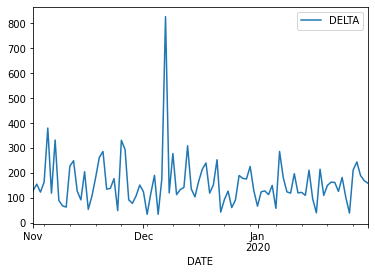

In [10]:
data_arima_prueba = data_arima[data_arima['ID'] == 14]
data_arima_prueba = data_arima_prueba.drop(['ID'], axis = 1)
data_arima_prueba.set_index('DATE', inplace = True)
data_arima_prueba.plot()

In [9]:
count = (data_arima_prueba['DELTA'] == 0).sum()
count

#El contador 5 tiene todos los valores 0

92

In [11]:
def selector_buenos_contadores_arima(dataframe, numero_dias_con_medida_0 = 10):
    '''
    Descripción: 
        Función que recibe un dataframe con información sobre mediciones de contadores y un umbral de días máximos en los que se admite tener
        lecturas de 0 y devuelve qué contadores son aptos para ARIMAS. 

    Inputs:
        dataframe (Pandas Dataframe): la última versión del dataframe de contadores limpiado, sin NAs, y con medidas diarias por filas.
        numero_dias_con_media_0 (int): umbral de dias con medida 0 que un contador puede tener como máximo para ser considerado bueno.

    Outputs:
        contadores_para_arima (list): lista con los identificadores de los contadores que se consideran buenos para ejecutar ARIMAS.

    '''
    contadores_para_arima = []
    for contador in range(0, len(dataframe['ID'].unique())):
        dataframe_objeto_analisis = dataframe[dataframe['ID'] == contador]
        if ((dataframe_objeto_analisis['DELTA'] == 0).sum()) <= numero_dias_con_medida_0:
            contadores_para_arima.append(contador)
    return contadores_para_arima

In [12]:
#Prueba
contadores_buenos = selector_buenos_contadores_arima(data_arima)
#Funciona

In [15]:
contadores_buenos

[0,
 2,
 3,
 4,
 6,
 7,
 9,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 22,
 23,
 24,
 25,
 26,
 28,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 51,
 52,
 54,
 55,
 56,
 57,
 58,
 59,
 61,
 62,
 64,
 66,
 68,
 69,
 71,
 74,
 75,
 76,
 77,
 80,
 81,
 82,
 83,
 84,
 87,
 89,
 91,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 118,
 119,
 121,
 124,
 125,
 126,
 127,
 128,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 174,
 175,
 177,
 178,
 179,
 181,
 182,
 183,
 184,
 186,
 187,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 200,
 201,
 203,
 204,
 205,
 206,
 207,
 208,
 210,
 213,
 214,
 215,
 216,
 217,
 218,
 220,
 221,
 222,
 223,
 224,
 225,
 227,
 228,

In [140]:
#Todos los contadores
todos_los_contadores = data['ID'].unique()
todos_los_contadores

array([   0,    1,    2, ..., 2748, 2749, 2756], dtype=int64)

In [32]:
# def arima_para_cada_contador(dataset_contadores, contadores, fecha = '2019-10-31'):
#     dataset_a_estudiar = dataset_contadores[dataset_contadores['DATE'] > fecha]
#     dataset_a_estudiar = dataset_a_estudiar.drop(['YEAR_DAY',
#                                                     'MEAN_CONSUMPTION',
#                                                     'VARIANCE_CONSUMPTION',
#                                                     'WEEKDAY','IS_WEEKEND',
#                                                     'sin_WEEKDAY',
#                                                     'cos_WEEKDAY',
#                                                     'sin_year_day',
#                                                     'cos_year_day',
#                                                     'PRECIPITATIONS',
#                                                     'MIN_TEMP',
#                                                     'MEAN_TEMP',
#                                                     'MAX_TEMP',
#                                                     'SUN',
#                                                     'IS_GOOD'], axis=1)
#     #Todas las predicciones en un dataframe
#     dataframe_predicciones = dataset_a_estudiar[dataset_a_estudiar['ID'] == 0]
#     dataframe_predicciones = dataframe_predicciones.drop(['ID', 'DELTA'], axis=1)
#     dataframe_predicciones.set_index('DATE', inplace = True)
#     for contador in contadores:
#         contador_a_estudiar = dataset_a_estudiar[dataset_a_estudiar['ID'] == contador]
#         #Drop ID
#         contador_a_estudiar = contador_a_estudiar.drop(['ID'], axis=1)
#         #Fechas a indices
#         contador_a_estudiar.set_index('DATE', inplace = True)
#         #MODELO POR CONTADOR
#         train = contador_a_estudiar[:(92-14)]
#         test = contador_a_estudiar[-14:]
#         arima_model = auto_arima(train, 
#                         start_p=0, 
#                         d=1, 
#                         start_q=0, 
#                         max_p=7, 
#                         max_d=7, 
#                         max_q=7, 
#                         start_P=0, 
#                         D=1, 
#                         start_Q=0, 
#                         max_P=7, 
#                         max_D=7, 
#                         max_Q=7, 
#                         m=12, 
#                         seasonal=True, 
#                         error_action='warn', 
#                         trace=True, 
#                         supress_warnings=True, 
#                         stepwise=True, 
#                         random_state=2517, 
#                         n_fits=100)
#         prediction = pd.DataFrame(arima_model.predict(n_periods = 14), index = test.index)
#         dataframe_predicciones[f'predict_cont_{contador}'] = prediction
#     return(dataframe_predicciones)            

In [123]:
###
data_sin_outliers = pd.read_pickle('../data/dataset_sin_outliers.pkl')
#data_arima = data_sin_outliers[data_sin_outliers['DATE'] > '2019-10-31']
data_sin_outliers.head(2)

,DELTA_0,DELTA_1,DELTA_2,DELTA_3,DELTA_4,DELTA_5,DELTA_6,DELTA_7,DELTA_8,DELTA_9,...,DELTA_2739,DELTA_2742,DELTA_2743,DELTA_2744,DELTA_2745,DELTA_2746,DELTA_2747,DELTA_2748,DELTA_2749,DELTA_2756
DATE,,,,,,,,,,,,,,,,,,,,,
2019-02-01,243.0,8.000000,0.0,492.0,247.56,314.208164,80.000000,45.0,4.0,109.0,...,15.0,205.637255,553.219919,553.219919,614.969444,582.933333,553.219919,435.831081,116.787879,553.219919
2019-02-02,236.0,11.690411,0.0,381.0,235.67,0.000000,174.597598,36.0,0.0,305.0,...,15.0,205.637255,395.367342,395.367342,614.969444,582.933333,395.367342,435.831081,116.787879,395.367342


In [120]:
data_empty = data_sin_outliers[['DELTA_0', 'DELTA_1']]
data_empty = data_empty.drop(['DELTA_0', 'DELTA_1'], axis=1)
data_empty = data_empty[-14:]
data_empty

""
DATE
2020-01-18
2020-01-19
2020-01-20
2020-01-21
2020-01-22
2020-01-23
2020-01-24
2020-01-25
2020-01-26


In [107]:
###
data_sin_outliers_2 = data_sin_outliers['DELTA_14']
data_sin_outliers_2.head(5)

0    101.00
1     54.06
2    189.94
3    155.00
4    158.00
Name: DELTA_14, dtype: float64

In [124]:
data_sin_outliers = data_sin_outliers.reset_index()
data_sin_outliers

,DATE,DELTA_0,DELTA_1,DELTA_2,DELTA_3,DELTA_4,DELTA_5,DELTA_6,DELTA_7,DELTA_8,...,DELTA_2739,DELTA_2742,DELTA_2743,DELTA_2744,DELTA_2745,DELTA_2746,DELTA_2747,DELTA_2748,DELTA_2749,DELTA_2756
0,2019-02-01,243.0,8.000000,0.0,492.0,247.56,314.208164,80.000000,45.000000,4.000000,...,15.0,205.637255,553.219919,553.219919,614.969444,582.933333,553.219919,435.831081,116.787879,553.219919
1,2019-02-02,236.0,11.690411,0.0,381.0,235.67,0.000000,174.597598,36.000000,0.000000,...,15.0,205.637255,395.367342,395.367342,614.969444,582.933333,395.367342,435.831081,116.787879,395.367342
2,2019-02-03,335.0,6.000000,0.0,313.0,254.33,0.000000,69.000000,144.052055,0.000000,...,15.0,205.637255,410.355298,410.355298,614.969444,582.933333,410.355298,435.831081,116.787879,410.355298
3,2019-02-04,252.0,12.000000,0.0,362.0,412.00,0.000000,270.000000,144.052055,7.603151,...,15.0,205.637255,516.355438,516.355438,614.969444,582.933333,516.355438,435.831081,116.787879,516.355438
4,2019-02-05,220.0,11.690411,0.0,380.0,269.00,0.000000,227.000000,63.000000,0.000000,...,15.0,205.637255,436.190532,436.190532,614.969444,582.933333,436.190532,435.831081,116.787879,436.190532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2020-01-27,213.0,4.000000,39.0,289.0,263.06,0.000000,204.000000,118.000000,7.603151,...,15.0,205.637255,414.904301,414.904301,614.969444,582.933333,414.904301,435.831081,116.787879,414.904301
361,2020-01-28,232.0,1.000000,40.0,380.0,303.94,0.000000,169.000000,135.000000,7.603151,...,15.0,205.637255,411.301918,411.301918,614.969444,582.933333,411.301918,435.831081,116.787879,411.301918
362,2020-01-29,403.0,2.000000,45.0,404.0,421.00,0.000000,195.000000,77.000000,7.603151,...,15.0,205.637255,418.423941,418.423941,614.969444,582.933333,418.423941,435.831081,116.787879,418.423941
363,2020-01-30,425.0,10.000000,27.0,339.0,420.00,0.000000,152.000000,39.000000,0.000000,...,15.0,205.637255,400.926486,400.926486,614.969444,582.933333,400.926486,435.831081,116.787879,400.926486


In [126]:
data_sin_outliers = data_sin_outliers[data_sin_outliers['DATE'] > '2019-10-31']
data_sin_outliers

,DATE,DELTA_0,DELTA_1,DELTA_2,DELTA_3,DELTA_4,DELTA_5,DELTA_6,DELTA_7,DELTA_8,...,DELTA_2739,DELTA_2742,DELTA_2743,DELTA_2744,DELTA_2745,DELTA_2746,DELTA_2747,DELTA_2748,DELTA_2749,DELTA_2756
273,2019-11-01,502.0,0.000000,1.0,531.0,411.85,0.0,233.0,228.0,0.000000,...,15.0,202.396176,407.622437,407.622437,612.383518,582.933333,407.622437,435.831081,116.787879,407.622437
274,2019-11-02,331.0,11.690411,1.0,468.0,343.22,0.0,211.0,108.0,0.000000,...,15.0,202.396176,380.309537,380.309537,612.383518,582.933333,380.309537,435.831081,116.787879,380.309537
275,2019-11-03,307.0,0.000000,16.0,411.0,367.78,0.0,151.0,308.0,0.000000,...,15.0,202.396176,423.227243,423.227243,612.383518,582.933333,423.227243,435.831081,116.787879,423.227243
276,2019-11-04,272.0,20.000000,23.0,350.0,276.00,0.0,258.0,95.0,3.000000,...,15.0,202.396176,582.274939,582.274939,612.383518,582.933333,582.274939,435.831081,116.787879,582.274939
277,2019-11-05,289.0,6.000000,27.0,407.0,298.56,0.0,183.0,125.0,0.000000,...,15.0,202.396176,513.808989,513.808989,612.383518,582.933333,513.808989,435.831081,116.787879,513.808989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2020-01-27,213.0,4.000000,39.0,289.0,263.06,0.0,204.0,118.0,7.603151,...,15.0,205.637255,414.904301,414.904301,614.969444,582.933333,414.904301,435.831081,116.787879,414.904301
361,2020-01-28,232.0,1.000000,40.0,380.0,303.94,0.0,169.0,135.0,7.603151,...,15.0,205.637255,411.301918,411.301918,614.969444,582.933333,411.301918,435.831081,116.787879,411.301918
362,2020-01-29,403.0,2.000000,45.0,404.0,421.00,0.0,195.0,77.0,7.603151,...,15.0,205.637255,418.423941,418.423941,614.969444,582.933333,418.423941,435.831081,116.787879,418.423941
363,2020-01-30,425.0,10.000000,27.0,339.0,420.00,0.0,152.0,39.0,0.000000,...,15.0,205.637255,400.926486,400.926486,614.969444,582.933333,400.926486,435.831081,116.787879,400.926486


In [127]:
data_sin_outliers.set_index('DATE', inplace = True)
data_sin_outliers

,DELTA_0,DELTA_1,DELTA_2,DELTA_3,DELTA_4,DELTA_5,DELTA_6,DELTA_7,DELTA_8,DELTA_9,...,DELTA_2739,DELTA_2742,DELTA_2743,DELTA_2744,DELTA_2745,DELTA_2746,DELTA_2747,DELTA_2748,DELTA_2749,DELTA_2756
DATE,,,,,,,,,,,,,,,,,,,,,
2019-11-01,502.0,0.000000,1.0,531.0,411.85,0.0,233.0,228.0,0.000000,265.0,...,15.0,202.396176,407.622437,407.622437,612.383518,582.933333,407.622437,435.831081,116.787879,407.622437
2019-11-02,331.0,11.690411,1.0,468.0,343.22,0.0,211.0,108.0,0.000000,236.0,...,15.0,202.396176,380.309537,380.309537,612.383518,582.933333,380.309537,435.831081,116.787879,380.309537
2019-11-03,307.0,0.000000,16.0,411.0,367.78,0.0,151.0,308.0,0.000000,162.0,...,15.0,202.396176,423.227243,423.227243,612.383518,582.933333,423.227243,435.831081,116.787879,423.227243
2019-11-04,272.0,20.000000,23.0,350.0,276.00,0.0,258.0,95.0,3.000000,95.0,...,15.0,202.396176,582.274939,582.274939,612.383518,582.933333,582.274939,435.831081,116.787879,582.274939
2019-11-05,289.0,6.000000,27.0,407.0,298.56,0.0,183.0,125.0,0.000000,246.0,...,15.0,202.396176,513.808989,513.808989,612.383518,582.933333,513.808989,435.831081,116.787879,513.808989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-27,213.0,4.000000,39.0,289.0,263.06,0.0,204.0,118.0,7.603151,149.0,...,15.0,205.637255,414.904301,414.904301,614.969444,582.933333,414.904301,435.831081,116.787879,414.904301
2020-01-28,232.0,1.000000,40.0,380.0,303.94,0.0,169.0,135.0,7.603151,166.0,...,15.0,205.637255,411.301918,411.301918,614.969444,582.933333,411.301918,435.831081,116.787879,411.301918
2020-01-29,403.0,2.000000,45.0,404.0,421.00,0.0,195.0,77.0,7.603151,101.0,...,15.0,205.637255,418.423941,418.423941,614.969444,582.933333,418.423941,435.831081,116.787879,418.423941


In [128]:
data_sin_outliers = data_sin_outliers['DELTA_0']
data_sin_outliers

DATE
2019-11-01    502.0
2019-11-02    331.0
2019-11-03    307.0
2019-11-04    272.0
2019-11-05    289.0
              ...  
2020-01-27    213.0
2020-01-28    232.0
2020-01-29    403.0
2020-01-30    425.0
2020-01-31    255.0
Name: DELTA_0, Length: 92, dtype: float64

In [129]:
train = data_sin_outliers[:(92-14)]
test = data_sin_outliers[-14:]

In [130]:
train

DATE
2019-11-01    502.0
2019-11-02    331.0
2019-11-03    307.0
2019-11-04    272.0
2019-11-05    289.0
              ...  
2020-01-13    115.0
2020-01-14    452.0
2020-01-15    210.0
2020-01-16    303.0
2020-01-17    278.0
Name: DELTA_0, Length: 78, dtype: float64

In [131]:
test

DATE
2020-01-18    421.0
2020-01-19    273.0
2020-01-20    306.0
2020-01-21    292.0
2020-01-22    460.0
2020-01-23    331.0
2020-01-24    368.0
2020-01-25    390.0
2020-01-26    304.0
2020-01-27    213.0
2020-01-28    232.0
2020-01-29    403.0
2020-01-30    425.0
2020-01-31    255.0
Name: DELTA_0, dtype: float64

In [89]:
data_sin_outliers_2.head(2)

,DATE,DELTA_14
273,2019-11-01,129.0
274,2019-11-02,155.0


            DELTA_14
DATE                
2019-11-01     129.0
2019-11-02     155.0
            DELTA_14
DATE                
2020-01-30     169.0
2020-01-31     159.0


<AxesSubplot:xlabel='DATE'>

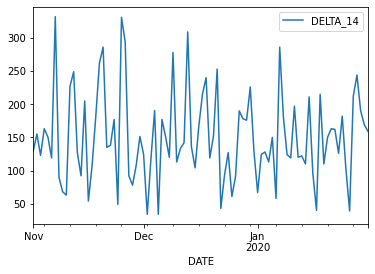

In [90]:
data_sin_outliers_2.set_index('DATE', inplace = True)
print(data_sin_outliers_2.head(2))
print(data_sin_outliers_2.tail(2))
data_sin_outliers_2.plot()

In [91]:
len(data_sin_outliers_2) #ESTO NO ME DA BUENA ESPINA. ARREGLADO

92

In [92]:
data_sin_outliers_2.isnull().values.any()

False

In [93]:
data_sin_outliers_3 = data_sin_outliers_2.drop(['DELTA_14'], axis=1)
data_sin_outliers_3

""
DATE
2019-11-01
2019-11-02
2019-11-03
2019-11-04
2019-11-05
...
2020-01-27
2020-01-28
2020-01-29


In [94]:
train = data_sin_outliers_2[:(92-14)]
test = data_sin_outliers_2[-14:]

In [95]:
train

,DELTA_14
DATE,
2019-11-01,129.000000
2019-11-02,155.000000
2019-11-03,123.000000
2019-11-04,163.000000
2019-11-05,150.482192
...,...
2020-01-13,122.000000
2020-01-14,110.000000
2020-01-15,211.000000


In [97]:
test

,DELTA_14
DATE,
2020-01-18,215.0
2020-01-19,110.0
2020-01-20,150.0
2020-01-21,163.0
2020-01-22,162.0
2020-01-23,126.0
2020-01-24,182.0
2020-01-25,102.0
2020-01-26,39.0


In [132]:
arima_model = auto_arima(train, 
                        start_p=0, 
                        d=1, 
                        start_q=0, 
                        max_p=7, 
                        max_d=7, 
                        max_q=7, 
                        start_P=0, 
                        D=1, 
                        start_Q=0, 
                        max_P=7, 
                        max_D=7, 
                        max_Q=7, 
                        m=12, 
                        seasonal=True, 
                        error_action='warn', 
                        trace=True, 
                        supress_warnings=True, 
                        stepwise=True, 
                        random_state=2517, 
                        n_fits=100)
prediction = pd.DataFrame(arima_model.predict(n_periods = 14), index = test.index)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=839.642, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=804.086, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=829.202, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=797.438, Time=0.35 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=798.554, Time=0.89 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=798.273, Time=0.85 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=800.227, Time=0.25 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=800.273, Time=1.43 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=821.192, Time=0.21 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=795.018, Time=0.41 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=799.517, Time=0.17 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=795.701, Time=0.87 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=795.464, Time=1.44 sec
 ARIMA(2,1,0)(1,1,1)[12]             

In [133]:
prediction

,0
DATE,
2020-01-18,365.249697
2020-01-19,317.707626
2020-01-20,372.683091
2020-01-21,361.801828
2020-01-22,271.285514
2020-01-23,250.523312
2020-01-24,272.933428
2020-01-25,279.926453
2020-01-26,332.993183


In [134]:
data_empty['predict_cont_X'] = prediction
data_empty

,predict_cont_X
DATE,
2020-01-18,365.249697
2020-01-19,317.707626
2020-01-20,372.683091
2020-01-21,361.801828
2020-01-22,271.285514
2020-01-23,250.523312
2020-01-24,272.933428
2020-01-25,279.926453
2020-01-26,332.993183


In [135]:
def arima_para_cada_contador(dataset_contadores, contadores, fecha = '2019-10-31'):
    
    #1ºResetear el indice date como variable (el df que se mete no tiene date como variable)
    dataset_a_estudiar = dataset_contadores.reset_index()
    #2ºFiltro por periodo para hacer ARIMA
    dataset_a_estudiar = dataset_contadores[dataset_contadores['DATE'] > fecha]
    #3ºUna vez se tiene el filtro de fecha, DATE pasa de nuevo a index
    dataset_a_estudiar.set_index('DATE', inplace = True)

    #Todas las predicciones en un dataframe de 14 filas (2 ultimas semanas de test)
    #para almacenar toda la informacion de los ARIMAs
    dataframe_predicciones = dataset_contadores[['DELTA_0', 'DELTA_1']] #Proceso "tosco"
    dataframe_predicciones = dataframe_predicciones.drop(['DELTA_0', 'DELTA_1'], axis=1) #Proceso "tosco"
    dataframe_predicciones = dataframe_predicciones[-14:] #Proceso "tosco"

    for contador in contadores:
        
        #1ºSe aisla el contador que se desea estudiar
        contador_a_estudiar = dataset_a_estudiar[f'DELTA_{contador}']

        #2ºUn modelo por contador
        train = contador_a_estudiar[:(92-14)]
        test = contador_a_estudiar[-14:]
        arima_model = auto_arima(train, 
                        start_p=0, 
                        d=1, 
                        start_q=0, 
                        max_p=7, 
                        max_d=7, 
                        max_q=7, 
                        start_P=0, 
                        D=1, 
                        start_Q=0, 
                        max_P=7, 
                        max_D=7, 
                        max_Q=7, 
                        m=12, 
                        seasonal=True, 
                        error_action='warn', 
                        trace=True, 
                        supress_warnings=True, 
                        stepwise=True, 
                        random_state=2517, 
                        n_fits=100)
        prediction = pd.DataFrame(arima_model.predict(n_periods = 14), index = test.index)

        #3ºLas predicciones por contador se pasan a una nueva columna del dataframe de return
        dataframe_predicciones[f'predict_cont_{contador}'] = prediction
        
    return(dataframe_predicciones)

In [142]:
data2 = pd.read_pickle('../data/dataset_sin_outliers.pkl')
data2

,DELTA_0,DELTA_1,DELTA_2,DELTA_3,DELTA_4,DELTA_5,DELTA_6,DELTA_7,DELTA_8,DELTA_9,...,DELTA_2739,DELTA_2742,DELTA_2743,DELTA_2744,DELTA_2745,DELTA_2746,DELTA_2747,DELTA_2748,DELTA_2749,DELTA_2756
DATE,,,,,,,,,,,,,,,,,,,,,
2019-02-01,243.0,8.000000,0.0,492.0,247.56,314.208164,80.000000,45.000000,4.000000,109.0,...,15.0,205.637255,553.219919,553.219919,614.969444,582.933333,553.219919,435.831081,116.787879,553.219919
2019-02-02,236.0,11.690411,0.0,381.0,235.67,0.000000,174.597598,36.000000,0.000000,305.0,...,15.0,205.637255,395.367342,395.367342,614.969444,582.933333,395.367342,435.831081,116.787879,395.367342
2019-02-03,335.0,6.000000,0.0,313.0,254.33,0.000000,69.000000,144.052055,0.000000,205.0,...,15.0,205.637255,410.355298,410.355298,614.969444,582.933333,410.355298,435.831081,116.787879,410.355298
2019-02-04,252.0,12.000000,0.0,362.0,412.00,0.000000,270.000000,144.052055,7.603151,287.0,...,15.0,205.637255,516.355438,516.355438,614.969444,582.933333,516.355438,435.831081,116.787879,516.355438
2019-02-05,220.0,11.690411,0.0,380.0,269.00,0.000000,227.000000,63.000000,0.000000,150.0,...,15.0,205.637255,436.190532,436.190532,614.969444,582.933333,436.190532,435.831081,116.787879,436.190532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-27,213.0,4.000000,39.0,289.0,263.06,0.000000,204.000000,118.000000,7.603151,149.0,...,15.0,205.637255,414.904301,414.904301,614.969444,582.933333,414.904301,435.831081,116.787879,414.904301
2020-01-28,232.0,1.000000,40.0,380.0,303.94,0.000000,169.000000,135.000000,7.603151,166.0,...,15.0,205.637255,411.301918,411.301918,614.969444,582.933333,411.301918,435.831081,116.787879,411.301918
2020-01-29,403.0,2.000000,45.0,404.0,421.00,0.000000,195.000000,77.000000,7.603151,101.0,...,15.0,205.637255,418.423941,418.423941,614.969444,582.933333,418.423941,435.831081,116.787879,418.423941


In [143]:
dataframe_predicciones = arima_para_cada_contador(data2, todos_los_contadores)

KeyError: 'DATE'

In [ ]:
dataframe_predicciones.to_pickle('../data/predicciones_enero_arima.pkl')

In [7]:
preds_enero[preds_enero < 0] = 0

In [8]:
preds_enero

,predict_cont_0,predict_cont_2,predict_cont_3,predict_cont_4,predict_cont_6,predict_cont_7,predict_cont_9,predict_cont_14,predict_cont_15,predict_cont_16,...,predict_cont_349,predict_cont_351,predict_cont_352,predict_cont_353,predict_cont_355,predict_cont_357,predict_cont_359,predict_cont_360,predict_cont_363,predict_cont_364
DATE,,,,,,,,,,,,,,,,,,,,,
2020-01-18,365.249697,38.908300,477.114617,208.029711,119.301171,119.061093,77.299652,102.077328,220.311021,363.918567,...,270.501703,368.759607,441.679053,296.989608,10132.824838,352.462041,152.302406,1488.258936,216.689223,57.948454
2020-01-19,317.707626,38.098945,308.436727,234.396966,230.387642,57.580160,0.000000,140.181449,236.668265,245.429321,...,335.966337,307.027117,344.373215,0.000000,11590.263788,261.279874,217.138868,1608.462492,340.295658,63.470739
2020-01-20,372.683091,36.019619,333.502741,342.402486,271.001057,53.953736,0.000000,111.567599,201.257206,177.572112,...,306.968594,348.221067,354.238970,0.000000,11347.221089,263.549314,137.526998,1463.894187,396.741245,54.232895
2020-01-21,361.801828,46.344488,333.812113,168.588490,246.015492,21.274115,97.288928,137.954633,193.722387,171.402868,...,242.479729,275.178463,380.495273,0.000000,11692.636699,235.577684,202.369939,1551.241336,259.285011,43.255396
2020-01-22,271.285514,38.059881,421.190602,219.428458,206.920028,94.210617,0.000000,63.168955,289.802057,212.401321,...,313.268502,297.465137,403.679216,0.000000,11100.636250,230.889764,152.757931,2179.878972,274.443562,68.781203
2020-01-23,250.523312,34.178412,391.306287,258.231615,195.609386,20.689793,0.000000,173.492150,283.372695,205.199235,...,366.758176,369.619170,384.349366,345.757955,10560.713285,218.382430,159.160021,1881.970688,283.458127,41.889587
2020-01-24,272.933428,35.742352,349.186539,241.193862,258.664037,101.069058,33.675309,555.831090,331.052998,258.799414,...,340.747967,298.992852,400.902535,0.000000,10532.026751,227.321716,111.987227,1610.374761,266.620831,77.146833
2020-01-25,279.926453,33.129320,334.480909,214.654808,235.224625,85.213056,0.000000,99.807860,339.857038,196.678303,...,141.629030,259.369825,376.734343,0.000000,12084.845613,123.327692,156.158127,1433.475442,342.914883,48.279688
2020-01-26,332.993183,44.795888,345.231113,246.315880,219.144588,67.113818,0.000000,200.278265,490.851012,267.321265,...,280.095641,221.447446,389.825484,0.000000,11326.259396,231.232590,144.329735,1807.503372,267.368513,76.706051


In [15]:
preds_enero.to_pickle('../data/predicciones_enero_arima.pkl')

In [1]:
def compute_error(pred, real):
    daily_rmses = []
    for i in range(7):
        daily_rmses.append((((real.iloc[:,i] - pred.iloc[:,i])**2/len(real.iloc[:,i])).sum())**(1/2))
    rmse_1 = sum(daily_rmses)/7
    
    first_week_pred_sum = pred.iloc[:,7].sum()
    second_week_pred_sum = pred.iloc[:,8].sum()
    first_week_real_sum = real.iloc[:,7].sum()
    second_week_real_sum = real.iloc[:,8].sum()
    
    first_week_rmse = (((first_week_real_sum - first_week_pred_sum)**2)/len(real.iloc[:,7]))**(1/2)
    second_week_rmse = (((second_week_real_sum - second_week_pred_sum)**2)/len(real.iloc[:,8]))**(1/2)
    rmse_2 = (first_week_rmse + second_week_rmse)/2
    
    return (rmse_1 + rmse_2)/2

In [16]:
results_df = preds_enero.T
results_df.columns = [['Dia_1','Dia_2','Dia_3','Dia_4','Dia_5','Dia_6','Dia_7',
                       'Dia_8','Dia_9','Dia_10','Dia_11','Dia_12','Dia_13','Dia_14']]
results_df['Semana_1'] = results_df[['Dia_1','Dia_2','Dia_3','Dia_4','Dia_5','Dia_6','Dia_7']].sum(axis=1)
results_df['Semana_2'] = results_df[['Dia_8','Dia_9','Dia_10','Dia_11','Dia_12','Dia_13','Dia_14']].sum(axis=1)
results_df.drop(['Dia_8','Dia_9','Dia_10','Dia_11','Dia_12','Dia_13','Dia_14'], axis=1, inplace=True)
results_df

C:\Users\Manuel\AppData\Local\Temp/ipykernel_18948/3649680272.py:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  results_df.drop(['Dia_8','Dia_9','Dia_10','Dia_11','Dia_12','Dia_13','Dia_14'], axis=1, inplace=True)


,Dia_1,Dia_2,Dia_3,Dia_4,Dia_5,Dia_6,Dia_7,Semana_1,Semana_2
predict_cont_0,365.249697,317.707626,372.683091,361.801828,271.285514,250.523312,272.933428,2212.184497,2380.607964
predict_cont_2,38.908300,38.098945,36.019619,46.344488,38.059881,34.178412,35.742352,267.351996,277.591698
predict_cont_3,477.114617,308.436727,333.502741,333.812113,421.190602,391.306287,349.186539,2614.549625,2601.189993
predict_cont_4,208.029711,234.396966,342.402486,168.588490,219.428458,258.231615,241.193862,1672.271588,1399.899073
predict_cont_6,119.301171,230.387642,271.001057,246.015492,206.920028,195.609386,258.664037,1527.898813,1507.412879
...,...,...,...,...,...,...,...,...,...
predict_cont_357,352.462041,261.279874,263.549314,235.577684,230.889764,218.382430,227.321716,1789.462823,1638.467447
predict_cont_359,152.302406,217.138868,137.526998,202.369939,152.757931,159.160021,111.987227,1133.243391,1101.262303
predict_cont_360,1488.258936,1608.462492,1463.894187,1551.241336,2179.878972,1881.970688,1610.374761,11784.081372,10700.138673
predict_cont_363,216.689223,340.295658,396.741245,259.285011,274.443562,283.458127,266.620831,2037.533657,2179.282658


In [18]:
test = pd.read_pickle('../data/test.pkl')
test = test.head(365)

In [21]:
test

,2020-01-18,2020-01-19,2020-01-20,2020-01-21,2020-01-22,2020-01-23,2020-01-24,first_week,second_week
ID,,,,,,,,,
0,421.00,273.0,306.00,292.00,460.00,331.00,368.00,2451.00,2222.00
1,0.00,216.0,14.00,3.00,0.00,3.00,5.67,241.67,54.33
2,28.00,33.0,48.00,35.00,33.00,20.00,37.00,234.00,272.00
3,485.00,394.0,237.00,297.00,312.00,321.00,439.00,2485.00,2792.00
4,365.00,387.0,370.00,293.00,287.00,361.00,203.00,2266.00,2216.00
...,...,...,...,...,...,...,...,...,...
360,1217.00,1193.0,2263.00,2451.00,2024.00,1339.00,2013.00,12500.00,11964.00
361,2.14,0.0,1.43,1.56,1.56,1.82,2.34,10.85,15.29
362,15.00,0.0,14.00,28.69,104.31,30.00,54.59,246.59,279.41


In [20]:
error = compute_error(results_df, test)
print('ARIMAS:', round(error,2))

ARIMAS: 25742.19
